# wetterdienst - A simple example

pip install wetterdienst

## Import modules necessary for general functioning

In [1]:
import warnings
warnings.filterwarnings("ignore")

from wetterdienst.dwd.observations import DwdObservationMetadata, DwdObservationRequest, \
    DwdObservationPeriod, DwdObservationResolution, DwdObservationParameter, DwdObservationDataset

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

Which parameters are available?

In [2]:
# all
print("All available combinations")
print(
    DwdObservationMetadata().discover_parameters()
)
# selection
print("Selection of daily historical data")
print(
    DwdObservationMetadata(
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    ).discover_parameters()
)

All available combinations
{'MINUTE_1': ['PRECIPITATION_HEIGHT', 'PRECIPITATION_HEIGHT_DROPLET', 'PRECIPITATION_HEIGHT_ROCKER', 'PRECIPITATION_FORM'], 'MINUTE_10': ['PRESSURE_AIR_STATION_HEIGHT', 'TEMPERATURE_AIR_200', 'TEMPERATURE_AIR_005', 'HUMIDITY', 'TEMPERATURE_DEW_POINT_200', 'TEMPERATURE_AIR_MAX_200', 'TEMPERATURE_AIR_MAX_005', 'TEMPERATURE_AIR_MIN_200', 'TEMPERATURE_AIR_MIN_005', 'WIND_GUST_MAX', 'WIND_SPEED_MIN', 'WIND_SPEED_ROLLING_MEAN_MAX', 'WIND_DIRECTION_MAX_VELOCITY', 'PRECIPITATION_DURATION', 'PRECIPITATION_HEIGHT', 'PRECIPITATION_INDICATOR_WR', 'RADIATION_SKY_DIFFUSE', 'RADIATION_GLOBAL', 'SUNSHINE_DURATION', 'RADIATION_SKY_LONG_WAVE', 'WIND_SPEED', 'WIND_DIRECTION'], 'HOURLY': ['TEMPERATURE_AIR_200', 'HUMIDITY', 'CLOUD_COVER_TOTAL', 'CLOUD_COVER_TOTAL_INDICATOR', 'CLOUD_TYPE_LAYER1', 'CLOUD_TYPE_LAYER1_ABBREVIATION', 'CLOUD_HEIGHT_LAYER1', 'CLOUD_COVER_LAYER1', 'CLOUD_TYPE_LAYER2', 'CLOUD_TYPE_LAYER2_ABBREVIATION', 'CLOUD_HEIGHT_LAYER2', 'CLOUD_COVER_LAYER2', 'CLOUD_T

## 1. First check the metadata to inform yourself of available stations
(here we pick historical daily precipitation - hdp)

In [3]:
request = DwdObservationRequest(
    parameter=DwdObservationDataset.PRECIPITATION_MORE,
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
)
print("Number of stations with available data: ", request.all().df.sum())
print("Some of the stations:")
request.all().df.head()

Number of stations with available data:  STATION_ID      0000100002000030000400006000070000800009000100...
HEIGHT                                                1.61503e+06
LATITUDE                                                   285395
LONGITUDE                                                 58625.7
STATION_NAME    AachAachen (Kläranlage)AachenAachen-BrandAalen...
STATE           Baden-WürttembergNordrhein-WestfalenNordrhein-...
dtype: object
Some of the stations:


,STATION_ID,FROM_DATE,TO_DATE,HEIGHT,LATITUDE,LONGITUDE,STATION_NAME,STATE
0,00001,1912-01-01 00:00:00+00:00,1986-06-30 00:00:00+00:00,478.0,47.8413,8.8493,Aach,Baden-Württemberg
1,00002,1951-01-01 00:00:00+00:00,2006-12-31 00:00:00+00:00,138.0,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen
2,00003,1891-01-01 00:00:00+00:00,2011-03-31 00:00:00+00:00,202.0,50.7827,6.0941,Aachen,Nordrhein-Westfalen
3,00004,1951-01-01 00:00:00+00:00,1979-10-31 00:00:00+00:00,243.0,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen
4,00006,1982-11-01 00:00:00+00:00,2021-03-08 00:00:00+00:00,455.0,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg


The metadata includes an id, the range of the measurements, the position
(including height) as well as place and state of it and if it has a file. With the
following plot we want to show a map of those stations:

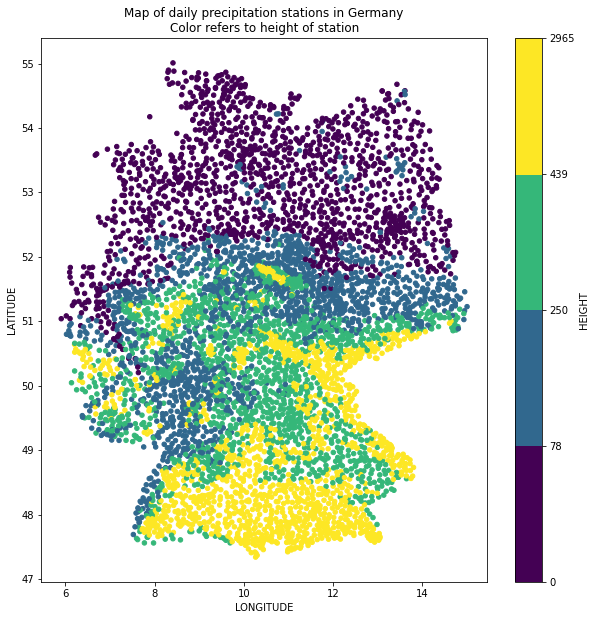

In [4]:
cmap = cm.get_cmap('viridis')
bounds = request.all().df.HEIGHT.quantile([0, 0.25, 0.5, 0.75, 1]).values
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
plot = request.all().df.plot.scatter(
    x="LONGITUDE", y="LATITUDE", c="HEIGHT", cmap=cmap, norm=norm, ax=ax)
plot.set_title("Map of daily precipitation stations in Germany\n"
               "Color refers to height of station")
plt.show()

## 2. The usual way of retrieving data

Let's get some data for the above request

In [5]:
print("Receiving historical daily climate data for Dresden-Klotzsche (1048)")
station_data = request.filter(station_id=[1048]).values.all().df

station_data.dropna(axis=0).head()

100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Receiving historical daily climate data for Dresden-Klotzsche (1048)


,STATION_ID,DATE,PARAMETER_SET,PARAMETER,VALUE,QUALITY
0,01048,1926-04-25 00:00:00+00:00,PRECIPITATION_MORE,RS,0,1
1,01048,1926-04-26 00:00:00+00:00,PRECIPITATION_MORE,RS,0,1
2,01048,1926-04-27 00:00:00+00:00,PRECIPITATION_MORE,RS,0,1
3,01048,1926-04-28 00:00:00+00:00,PRECIPITATION_MORE,RS,0,1
4,01048,1926-04-29 00:00:00+00:00,PRECIPITATION_MORE,RS,0,1


See that DATE is already parsed, so we can easily get some nice graphs with matplotlib,
which we will do in the next part. We can also request direct parameters from the given
parameter sets. We know that climate_summary contains TMK, TNK, TXK and RSK, so let's
request those. This option will automatically tidy the data.

In [6]:
print("Receiving historical daily temperature and precipitation for Dresden-Klotzsche "
      "(1048).")

request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.TEMPERATURE_AIR_200,
        DwdObservationParameter.DAILY.TEMPERATURE_AIR_MAX_200,
        DwdObservationParameter.DAILY.TEMPERATURE_AIR_MIN_200,
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
).filter(station_id=(1048, ))

station_data = request.values.all().df

station_data.dropna(axis=0).head()

Receiving historical daily temperature and precipitation for Dresden-Klotzsche (1048).


100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


,STATION_ID,DATE,PARAMETER_SET,PARAMETER,VALUE,QUALITY
0,01048,1934-01-01 00:00:00+00:00,CLIMATE_SUMMARY,TEMPERATURE_AIR_200,0.5,1
1,01048,1934-01-02 00:00:00+00:00,CLIMATE_SUMMARY,TEMPERATURE_AIR_200,-0.1,1
2,01048,1934-01-03 00:00:00+00:00,CLIMATE_SUMMARY,TEMPERATURE_AIR_200,-0.7,1
3,01048,1934-01-04 00:00:00+00:00,CLIMATE_SUMMARY,TEMPERATURE_AIR_200,-1.6,1
4,01048,1934-01-05 00:00:00+00:00,CLIMATE_SUMMARY,TEMPERATURE_AIR_200,0.9,1


## 3. Let's create some plots

Now that we have data, let's create some plots! We can create a time series/histogram of
the temperatures and precipitation

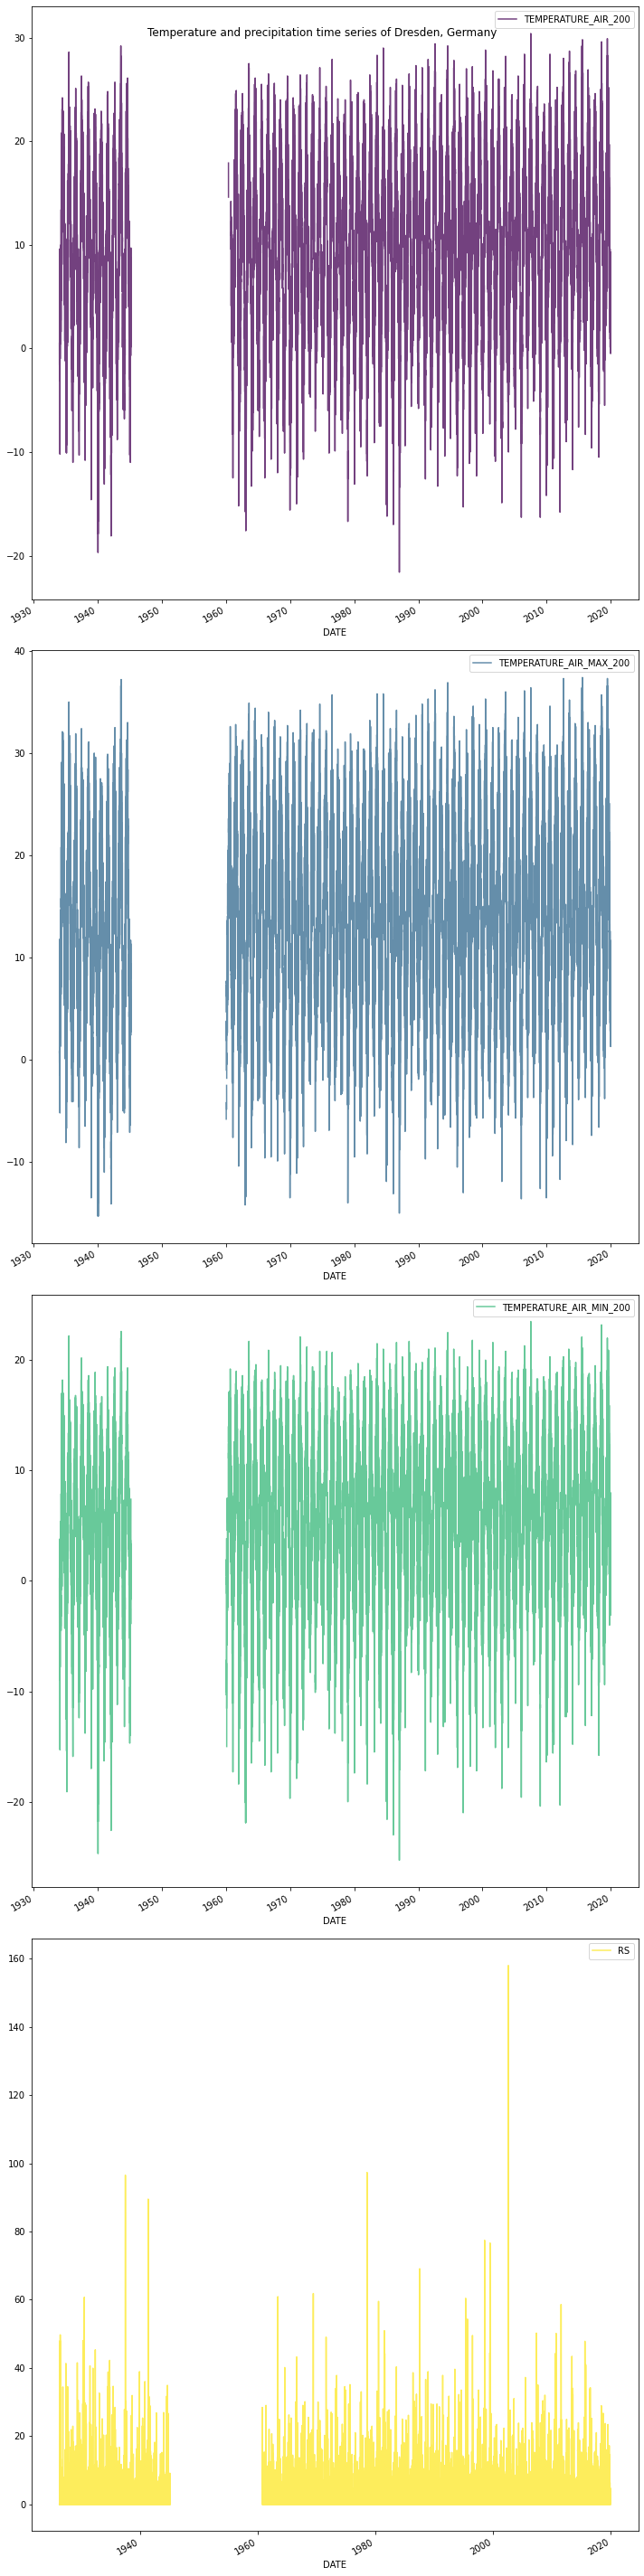

In [7]:
cmap = plt.get_cmap('viridis', 4)
colors = cmap.colors

PARAMETERS = ["TNK", "TMK", "TXK", "RSK"]

station_data_grouped = station_data.groupby(station_data["PARAMETER"], observed=True)

fig, axes = plt.subplots(nrows=len(PARAMETERS), tight_layout=True, figsize=(10, 40))

for (parameter, group), ax, color in zip(station_data_grouped, axes, colors):
    group.plot(x="DATE", y="VALUE", label=parameter, alpha=.75, ax=ax, c=color)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Temperature and precipitation time series of Dresden, Germany")

plt.show()

## 4. Create yearly values

In [8]:
import numpy as np
import pandas as pd
station_data_yearly = []

for (year, parameter), group in station_data.groupby(
        [station_data["DATE"].dt.year, "PARAMETER"], as_index=False, observed=True):
    if parameter == "RSK":
        station_data_yearly.append(group.dropna().agg({"VALUE": np.sum}))
    else:
        station_data_yearly.append(group.dropna().agg({"VALUE": np.mean}))

station_data_yearly = pd.concat(station_data_yearly)

station_data_yearly

VALUE     2.705976
VALUE     2.040000
VALUE     1.729235
VALUE     1.808493
VALUE     2.591233
           ...    
VALUE     1.153699
VALUE    11.229041
VALUE    15.583836
VALUE     6.808493
VALUE     1.378904
Length: 296, dtype: float64

## 5. Find a station

We may want to find a station near to a certain area. Therefor simply call get_nearest_station

In [9]:
DwdObservationRequest(
    parameter=DwdObservationDataset.CLIMATE_SUMMARY,
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL,
    start_date="2000-01-01",
    end_date="2010-01-01"
).nearby_number(
    51.05089,
    13.73832,
    5
).df

start_date and end_date filtering limited to defined periods [<Period.HISTORICAL: 'historical'>]


,STATION_ID,FROM_DATE,TO_DATE,HEIGHT,LATITUDE,LONGITUDE,STATION_NAME,STATE,DISTANCE_TO_LOCATION
0,01047,1828-01-01 00:00:00+00:00,1915-12-31 00:00:00+00:00,112.0,51.0557,13.7274,Dresden (Mitte),Sachsen,1.326824
1,01051,1936-01-01 00:00:00+00:00,2021-03-08 00:00:00+00:00,120.0,51.0248,13.7750,Dresden-Strehlen,Sachsen,5.005144
2,01048,1934-01-01 00:00:00+00:00,2021-03-08 00:00:00+00:00,227.0,51.1280,13.7543,Dresden-Klotzsche,Sachsen,8.756424
3,05282,1917-01-01 00:00:00+00:00,1974-06-30 00:00:00+00:00,246.0,51.1197,13.6744,Wahnsdorf bei Dresden,Sachsen,10.443200
4,01050,1949-01-01 00:00:00+00:00,2021-03-08 00:00:00+00:00,112.0,51.0221,13.8470,Dresden-Hosterwitz,Sachsen,12.501498
